# Общий обзор
Создание рекомендательной системы, использующей метод коллаборативной фильтрации на основе разложения матрицы (SVD). Она предсказывает рейтинги игр для пользователей на основе их прошлых оценок и рекомендует игры, которые пользователи еще не оценили. Основная цель  — предоставить персонализированные рекомендации, которые помогут пользователям найти интересные игры на платформе Steam

# Загрузка и распаковка данных

In [1]:
!kaggle datasets download -d antonkozyriev/game-recommendations-on-steam

Dataset URL: https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam
License(s): CC0-1.0
100% 660M/660M [00:11<00:00, 62.1MB/s]
100% 660M/660M [00:11<00:00, 62.8MB/s]


In [2]:
!unzip game-recommendations-on-steam.zip

Archive:  game-recommendations-on-steam.zip
  inflating: games.csv               
  inflating: games_metadata.json     
  inflating: recommendations.csv     
  inflating: users.csv               


In [3]:
pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357245 sha256=6d47c0c63f145ffcf64dfc442a89bd908829543d0236f1ab64d4205d27abe1c5
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [4]:
import pandas as pd
import numpy as np
import json
import pickle
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ndcg_score

In [5]:
# функция, уменьшающая использование памяти
def reduce_memory(df):
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
        elif df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
    return df

# Загрузка и предварительная обработка и иследование данных

In [6]:
games_df = reduce_memory(pd.read_csv('games.csv'))
recommendations_df = reduce_memory(pd.read_csv('recommendations.csv'))
users_df = reduce_memory(pd.read_csv('users.csv'))
games_metadata = pd.read_json('games_metadata.json', lines=True)

In [7]:
games_df.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True


In [8]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app_id          50872 non-null  int32  
 1   title           50872 non-null  object 
 2   date_release    50872 non-null  object 
 3   win             50872 non-null  bool   
 4   mac             50872 non-null  bool   
 5   linux           50872 non-null  bool   
 6   rating          50872 non-null  object 
 7   positive_ratio  50872 non-null  int32  
 8   user_reviews    50872 non-null  int32  
 9   price_final     50872 non-null  float32
 10  price_original  50872 non-null  float32
 11  discount        50872 non-null  float32
 12  steam_deck      50872 non-null  bool   
dtypes: bool(4), float32(3), int32(3), object(3)
memory usage: 2.5+ MB


In [9]:
recommendations_df.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.299999,51580,0
1,304390,4,0,2017-02-17,False,11.500000,2586,1
2,1085660,2,0,2019-11-17,True,336.500000,253880,2
3,703080,0,0,2022-09-23,True,27.400000,259432,3
4,526870,0,0,2021-01-10,True,7.900000,23869,4


In [10]:
recommendations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41154794 entries, 0 to 41154793
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int32  
 1   helpful         int32  
 2   funny           int32  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float32
 6   user_id         int32  
 7   review_id       int32  
dtypes: bool(1), float32(1), int32(5), object(1)
memory usage: 1.3+ GB


In [11]:
users_df.head()

,user_id,products,reviews
0,7360263,359,0
1,14020781,156,1
2,8762579,329,4
3,4820647,176,4
4,5167327,98,2


In [12]:
games_metadata.head()

,app_id,description,tags
0,13500,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
1,22364,,[Action]
2,113020,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
3,226560,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."
4,249050,Dungeon of the Endless is a Rogue-Like Dungeon...,"[Roguelike, Strategy, Tower Defense, Pixel Gra..."


In [13]:
games_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   app_id       50872 non-null  int64 
 1   description  50872 non-null  object
 2   tags         50872 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [14]:
games_df = games_df[['app_id', 'rating']]
games_df.head()

,app_id,rating
0,13500,Very Positive
1,22364,Positive
2,113020,Very Positive
3,226560,Mixed
4,249050,Very Positive


In [15]:
games_df['rating'].unique()

array(['Very Positive', 'Positive', 'Mixed', 'Mostly Positive',
       'Overwhelmingly Positive', 'Negative', 'Mostly Negative',
       'Overwhelmingly Negative', 'Very Negative'], dtype=object)

In [16]:
# преобразование текстовых оценок в числовые значения
rating_map = {
    'Overwhelmingly Positive': 5,
    'Very Positive': 4.5,
    'Positive': 4,
    'Mostly Positive': 3.5,
    'Mixed': 3,
    'Mostly Negative': 2.5,
    'Negative': 2,
    'Very Negative': 1.5,
    'Overwhelmingly Negative': 1
}


games_df['rating_numeric'] = games_df['rating'].map(rating_map)
games_df.head()

,app_id,rating,rating_numeric
0,13500,Very Positive,4.5
1,22364,Positive,4.0
2,113020,Very Positive,4.5
3,226560,Mixed,3.0
4,249050,Very Positive,4.5


<ipython-input-17-253a1bf1835e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.countplot( x='rating_numeric' , data = games_df ,


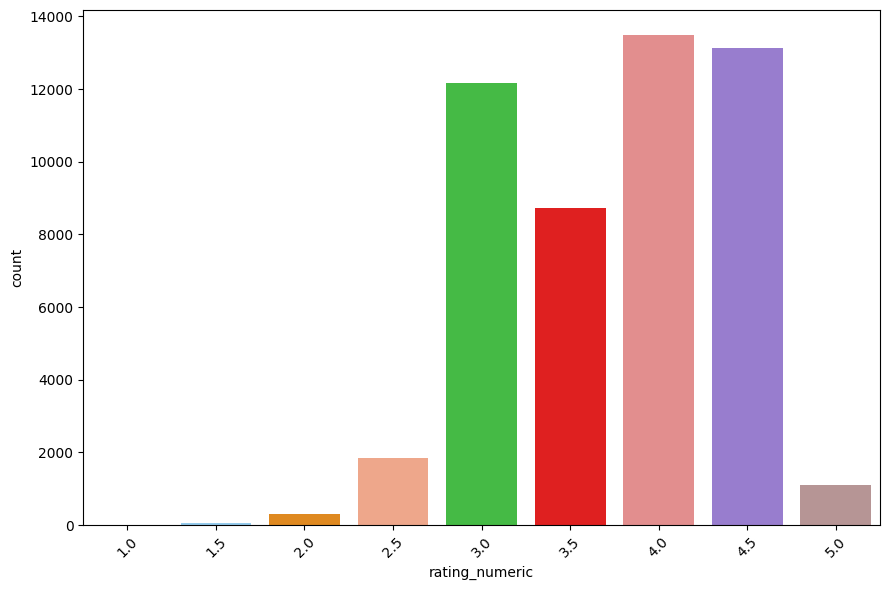

In [17]:
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(9, 6))
sn.countplot( x='rating_numeric' , data = games_df ,
    palette = [
    'DeepSkyBlue',        # 5.0 Very Positive
    'LightSkyBlue',       # 4.5 Positive
    'DarkOrange',         # 4.0 Mixed
    'LightSalmon',        # 3.5 Mostly Positive
    'LimeGreen',          # 3.0 Overwhelmingly Positive
    'Red',                # 2.5 Negative
    'LightCoral',         # 2.0 Mostly Negative
    'MediumPurple',       # 1.5 Overwhelmingly Negative
    'RosyBrown'           # 1.0 Very Negative
])
plt.xticks(rotation=45)
plt.tight_layout()

In [18]:
# удаление ненужного столбца
games_df = games_df[['app_id', 'rating_numeric']]
games_df.head()

,app_id,rating_numeric
0,13500,4.5
1,22364,4.0
2,113020,4.5
3,226560,3.0
4,249050,4.5


In [19]:
recommendations_df = recommendations_df[['app_id','user_id']]
recommendations_df.head()

,app_id,user_id
0,975370,51580
1,304390,2586
2,1085660,253880
3,703080,259432
4,526870,23869


# Создание таблицы для коллаборативной модели

In [22]:
collaborative_df = pd.merge(recommendations_df, games_df, on='app_id', how='inner')
collaborative_df = collaborative_df[['user_id', 'app_id', 'rating_numeric']]
collaborative_df.tail()

,user_id,app_id,rating_numeric
41154789,549720,1643850,4.5
41154790,11254404,1643850,4.5
41154791,5717958,1643850,4.5
41154792,4910050,1643850,4.5
41154793,5912758,1643850,4.5


In [23]:
collaborative_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41154794 entries, 0 to 41154793
Data columns (total 3 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         int32  
 1   app_id          int32  
 2   rating_numeric  float64
dtypes: float64(1), int32(2)
memory usage: 628.0 MB


In [24]:
collaborative_df['rating_numeric'] = collaborative_df['rating_numeric'].astype('float32')

In [25]:
collaborative_df.isnull().sum()

user_id           0
app_id            0
rating_numeric    0
dtype: int64

In [26]:
rating_distribution = collaborative_df['rating_numeric'].describe()
rating_distribution

count    4.115479e+07
mean     4.383415e+00
std      5.902895e-01
min      1.000000e+00
25%      4.500000e+00
50%      4.500000e+00
75%      4.500000e+00
max      5.000000e+00
Name: rating_numeric, dtype: float64

# Фильтрация данных
для удаления пользователей, которые редко оценивали приложения и приложений с малым количеством оценок. Процесс повторяется до тех пор, пока все пользователи и приложения не удовлетворяют минимальным требованиям

In [27]:
user_rating_counts = collaborative_df['user_id'].value_counts()
app_rating_counts = collaborative_df['app_id'].value_counts()
user_rating_counts, app_rating_counts

(user_id
 11764552    6045
 5112758     4152
 11656130    3840
 5669734     3479
 11553593    3392
             ... 
 7885754        1
 1086265        1
 6848886        1
 7689022        1
 2344049        1
 Name: count, Length: 13781059, dtype: int64,
 app_id
 440        319492
 252490     270684
 1091500    226414
 730        219737
 570        216914
             ...  
 1814870         1
 1136110         1
 1771540         1
 2094300         1
 498940          1
 Name: count, Length: 37610, dtype: int64)

Макс. рейтингов у одного пользователя: 6045. Самое популярное приложение 319,492 рейтинг. Есть пользователи и приложения с одиним рейтингом (может быть шумом)

In [28]:
min_ratings_per_user = 5
min_ratings_per_app = 5


# повторяем фильтрацию до тех пор, пока все пользователи и приложения не будут удовлетворять условиям
while True:
    initial_user_count = collaborative_df['user_id'].nunique()
    initial_app_count = collaborative_df['app_id'].nunique()

    # фильтрация пользователей
    user_counts = collaborative_df['user_id'].value_counts()
    users_to_keep = user_counts[user_counts >= min_ratings_per_user].index
    collaborative_df = collaborative_df[collaborative_df['user_id'].isin(users_to_keep)]

    # фильтрация приложений
    app_counts = collaborative_df['app_id'].value_counts()
    apps_to_keep = app_counts[app_counts >= min_ratings_per_app].index
    collaborative_df = collaborative_df[collaborative_df['app_id'].isin(apps_to_keep)]

    # проверяем, изменилось ли количество пользователей и приложений
    final_user_count = collaborative_df['user_id'].nunique()
    final_app_count = collaborative_df['app_id'].nunique()

    if initial_user_count == final_user_count and initial_app_count == final_app_count:
        break

In [29]:
# повторная проверка распределения рейтингов
user_rating_counts = collaborative_df['user_id'].value_counts()
app_rating_counts = collaborative_df['app_id'].value_counts()
user_rating_counts.describe(), app_rating_counts.describe()

(count    1.910450e+06
 mean     1.174288e+01
 std      1.944924e+01
 min      5.000000e+00
 25%      6.000000e+00
 50%      8.000000e+00
 75%      1.200000e+01
 max      5.985000e+03
 Name: count, dtype: float64,
 count     34369.000000
 mean        652.744537
 std        3663.220811
 min           5.000000
 25%          14.000000
 50%          38.000000
 75%         163.000000
 max      135819.000000
 Name: count, dtype: float64)

# Подготовка данных для модели SVD

In [30]:
# сэмплирование данных
sampled_df = collaborative_df.sample(frac=0.1, random_state=42)  # берем 10% данных

In [31]:
# загрузка данных
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(sampled_df[['user_id', 'app_id', 'rating_numeric']], reader)

# разделение данных на тренировочные и тестовые
trainset, testset = train_test_split(data, test_size=0.2)

# Модель SVD

In [32]:
model = SVD()
model.fit(trainset)

In [33]:
# проверка на тестовом наборе
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)
print(f'RMSE: {rmse}')

RMSE: 0.1410
RMSE: 0.14104176812603644


# Кросс-валидация и оценка модели

In [34]:
from surprise.model_selection import cross_validate

# использование кросс-валидации для оценки модели
cross_val_results = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

# RMSE и MAE
mean_rmse = cross_val_results['test_rmse'].mean()
mean_mae = cross_val_results['test_mae'].mean()
print(f'Mean RMSE: {mean_rmse}')
print(f'Mean MAE: {mean_mae}')

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.1514  0.1523  0.1505  0.1514  0.0008  
MAE (testset)     0.0525  0.0525  0.0523  0.0524  0.0001  
Fit time          62.63   62.83   66.78   64.08   1.91    
Test time         9.29    10.36   10.08   9.91    0.45    
Mean RMSE: 0.151400856240528
Mean MAE: 0.05243576292237497


результаты показывают, что модель SVD хорошо обучена и предсказывает оценки с низкой ошибкой. Низкое стандартное отклонение указывает на стабильность модели

# Проверка предсказаний

In [37]:
predictions = model.test(testset)
for prediction in predictions[:10]:  # вывод первых 10 предсказаний
    print(f"User: {prediction.uid}, Item: {prediction.iid}, Actual Rating: {prediction.r_ui}, Predicted Rating: {prediction.est}")

User: 5919409, Item: 725270, Actual Rating: 4.5, Predicted Rating: 4.4898947578533495
User: 8693517, Item: 1088710, Actual Rating: 4.5, Predicted Rating: 4.400886939315565
User: 1945101, Item: 319630, Actual Rating: 5.0, Predicted Rating: 4.986403405259137
User: 6544916, Item: 383150, Actual Rating: 4.5, Predicted Rating: 4.5178961497754
User: 8220585, Item: 10, Actual Rating: 5.0, Predicted Rating: 4.995545558729805
User: 5280705, Item: 242760, Actual Rating: 5.0, Predicted Rating: 4.986689059670177
User: 12877826, Item: 15170, Actual Rating: 4.5, Predicted Rating: 4.487523430313365
User: 11295234, Item: 1846170, Actual Rating: 4.5, Predicted Rating: 4.505961213718167
User: 13751721, Item: 945360, Actual Rating: 4.5, Predicted Rating: 4.499294234644775
User: 11190635, Item: 1064420, Actual Rating: 4.5, Predicted Rating: 4.520625887684998


# топ-K рекомендаций для указанного пользователя

In [48]:
def get_top_k_recommendations(model, user_id, games_df, collaborative_df, k=10):
    # получение списка всех игр
    all_games = games_df['app_id'].unique()

    # получение списка игр, которые пользователь уже оценил
    user_rated_games = collaborative_df[collaborative_df['user_id'] == user_id]['app_id']

    # исключение уже оцененных игр
    games_to_predict = [game for game in all_games if game not in user_rated_games]

    # прогнозирование рейтингов для всех неоцененных игр
    predictions = [model.predict(user_id, game) for game in games_to_predict]

    # сортировка прогнозов по предсказанному рейтингу
    top_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:k]

    # получение информации о топ-K играх
    top_game_ids = [pred.iid for pred in top_predictions]

    return top_game_ids

In [49]:
# ввод ID пользователя и количества рекомендаций
user_id = input("Введите ID пользователя: ")
k = int(input("Введите количество рекомендаций: "))

Введите ID пользователя: 11190635
Введите количество рекомендаций: 10


In [50]:
# получение топ-K рекомендаций
top_k_games = get_top_k_recommendations(model, user_id, games_df, collaborative_df, k)
print(f"Топ-{k} рекомендаций для пользователя {user_id}:")
print(top_k_games)

Топ-10 рекомендаций для пользователя 11190635:
[33100, 367580, 230270, 1218900, 218410, 279800, 788770, 1806840, 658920, 866440]


# Сохранение модели

In [52]:
from google.colab import drive
import pickle

# подключение к Google Drive
drive.mount('/content/drive')

# сохранение модели SVD
model_path = '/content/drive/MyDrive/svd_model.pkl'

with open(model_path, 'wb') as f:
    pickle.dump(model, f)

print(f"Модель сохранена по пути: {model_path}")

Mounted at /content/drive
Модель сохранена по пути: /content/drive/MyDrive/svd_model.pkl
